In [9]:
from vae import VAE
from utils import * 

In [12]:
def test(model, data):
    model.eval()
    test_loss = []
    for img, label in data:
        img = img.to(device)
        with torch.no_grad():
            output = model(img)
        loss = model.loss_function(*output)
        test_loss.append(loss)

    loss_total = [loss["loss"].cpu().detach() for loss in test_loss]
    recons_loss_total = [loss["reconstruction_loss"].cpu().detach() for loss in test_loss]
    kld_loss_total = [loss["kld_loss"].cpu().detach() for loss in test_loss]

    model.train()

    return {
        "loss": sum(loss_total) / len(loss_total),
        "recons_loss": sum(recons_loss_total) / len(recons_loss_total),
        "kld_loss": sum(kld_loss_total) / len(kld_loss_total),
    }

def train(train_set, epochs: int = EPOCHS):
    net = VAE(LATENT_DIMS).to(device)
    net.train()
    optim = torch.optim.AdamW(net.parameters(), lr=0.01)
    test_loss = {
        'base': [],
        'augmented': []
    }
    train_loss = []
    for i in range(epochs):
        for img, label in tqdm(train_set, desc=f"Epoch {i + 1:02}/{epochs}"):
            img = img.to(device)

            optim.zero_grad()

            reconstructed_image, original, mu, log_var = net(img)
            loss = net.loss_function(reconstructed_image, original, mu, log_var, kld_weight=0.001)
            train_loss.append(loss)
            loss["loss"].backward()
            optim.step()

        test_loss["base"].append(test(net, test_base))
        test_loss["augmented"].append(test(net, test_augment))
    return net, test_loss, train_loss

In [13]:
base_model, test_loss, train_loss = train(train_base, epochs=1)
print(f"Accuracy of base model on base dataset: {get_linear_classification_acc(base_model, train_base, test_base)}")
print(f"Accuracy of base model on augmented dataset: {get_linear_classification_acc(base_model, train_augment, test_augment)}")

Epoch 01/1: 100%|██████████| 938/938 [00:15<00:00, 61.57it/s]


Accuracy of base model on base dataset: 0.7515

Accuracy of base model on augmented dataset: 0.3842

In [6]:
augment_model, augment_test_loss, augment_train_loss = train(train_augment)
print(f"Accuracy of augmented model on base dataset: {get_linear_classification_acc(augment_model, train_base, test_base)}")
print(f"Accuracy of augmented model on augmented dataset: {get_linear_classification_acc(augment_model, train_augment, test_augment)}")

Epoch 20/20: 100%|██████████| 938/938 [00:25<00:00, 37.18it/s]


Accuracy of augmented model on base dataset: 0.7467

Accuracy of augmented model on augmented dataset: 0.4336

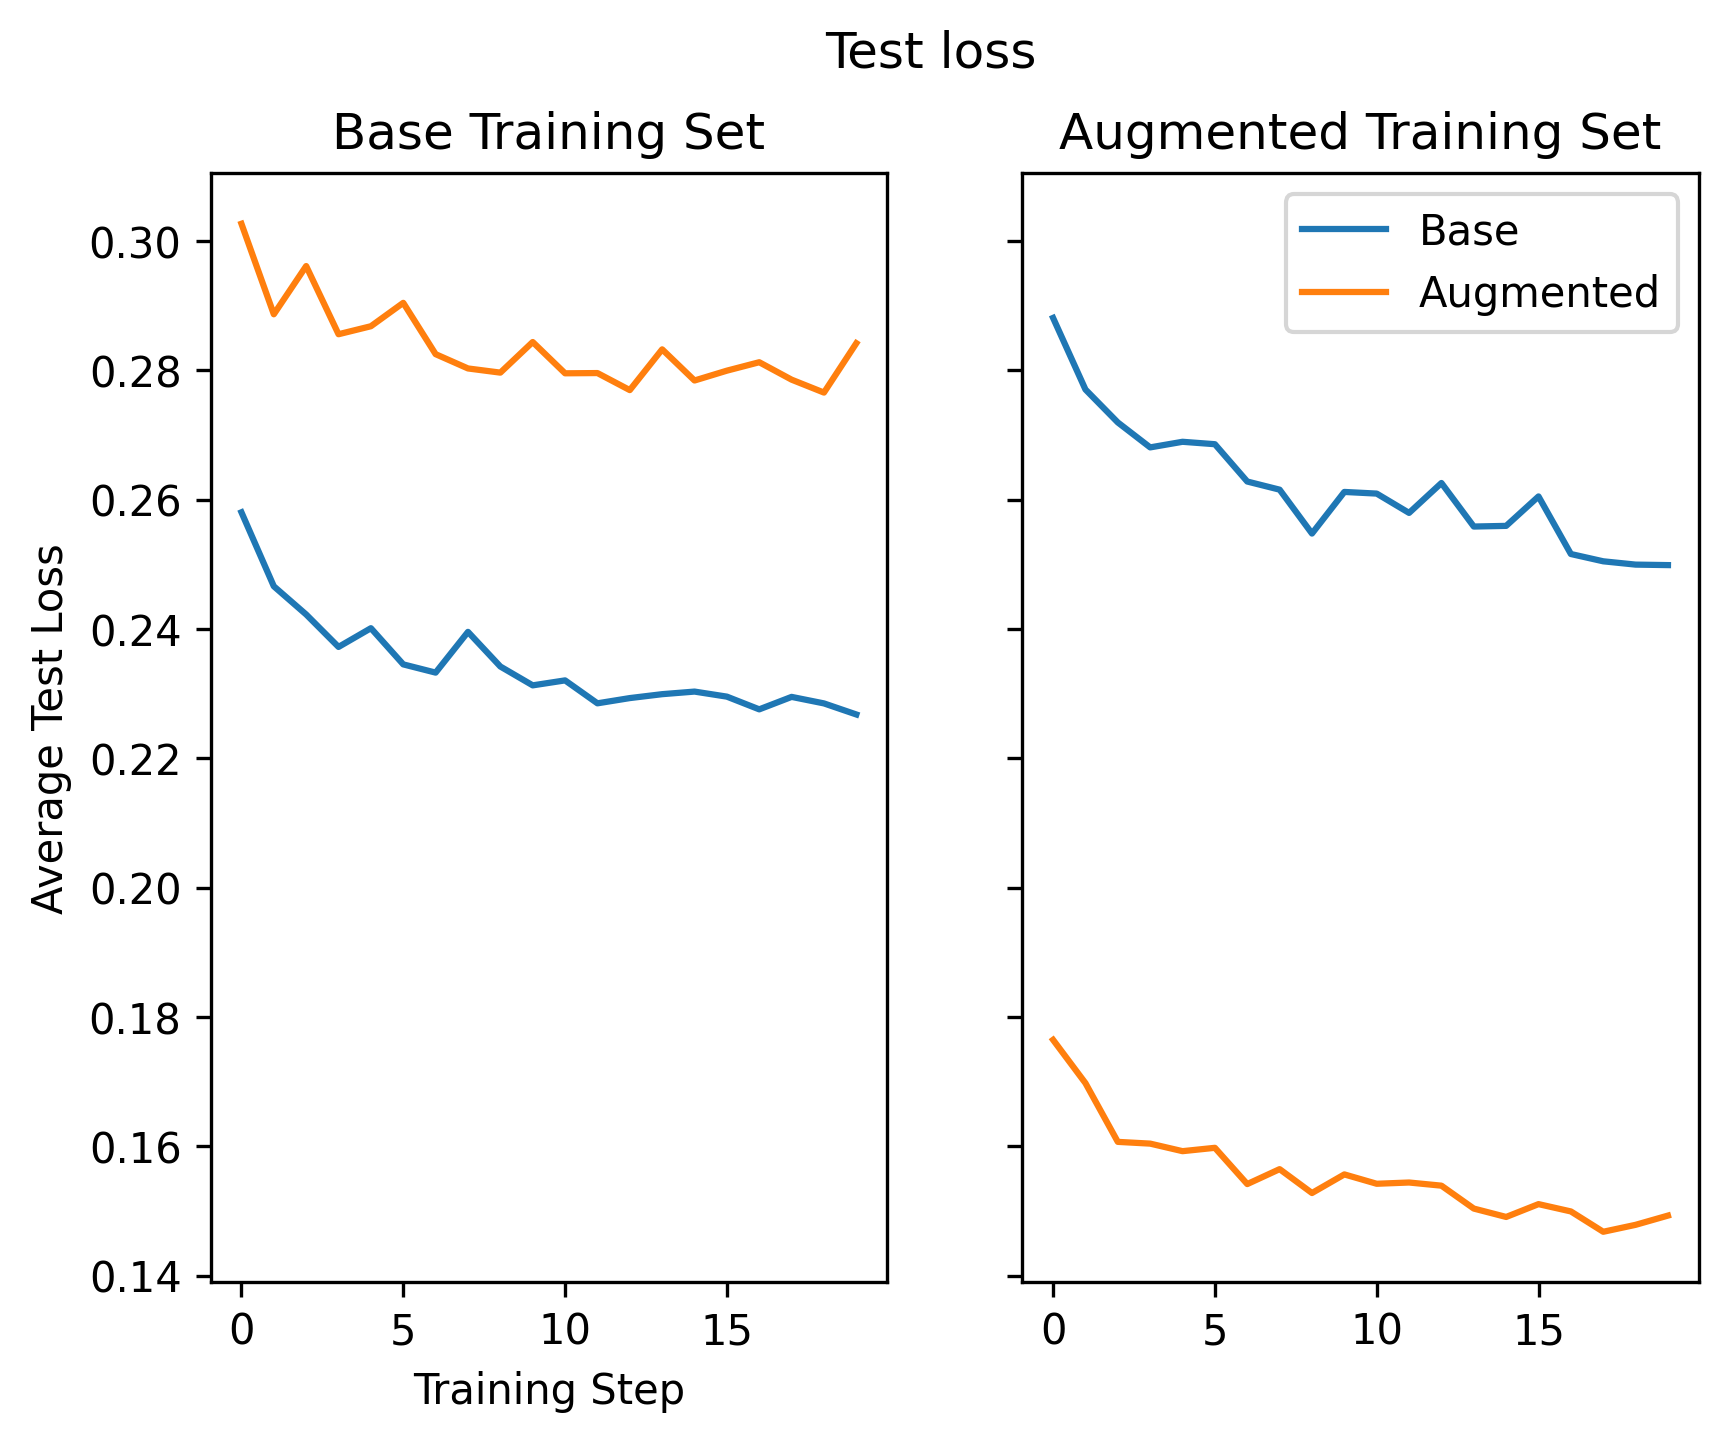

In [7]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

fig.suptitle("Test loss")
axs[0].title.set_text("Base Training Set")
axs[1].title.set_text("Augmented Training Set")

axs[0].plot([loss['loss'] for loss in test_loss['base']], label="Base")
axs[0].set_xlabel("Training Step")
axs[0].set_ylabel("Average Test Loss")
axs[0].plot([loss['loss'] for loss in test_loss['augmented']], label="Augmented")

axs[1].plot([loss['loss'] for loss in augment_test_loss['base']], label="Base")
axs[1].plot([loss['loss'] for loss in augment_test_loss['augmented']], label="Augmented")

plt.legend()
plt.show()

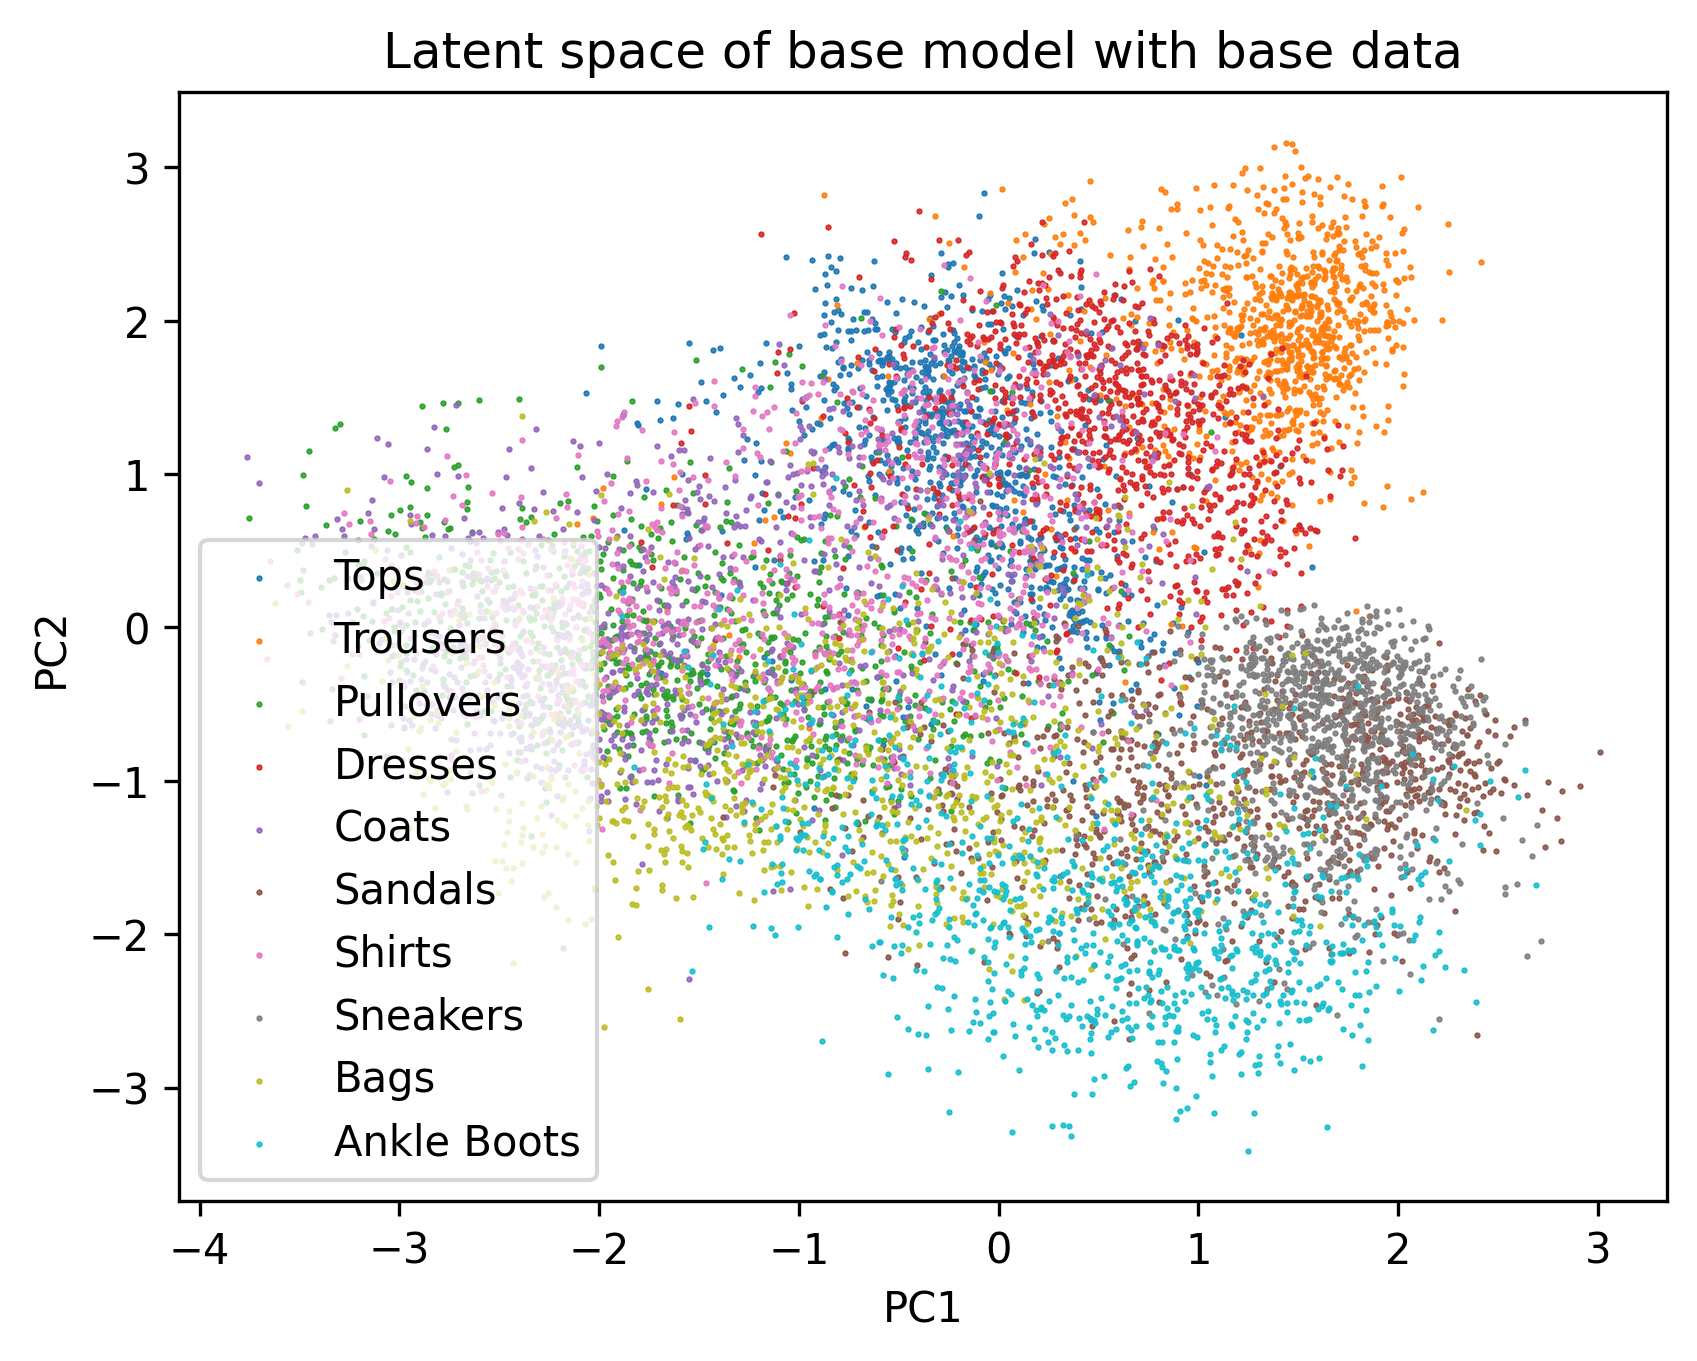

In [8]:
latent_plot(base_model, test_base, title="Latent space of base model with base data")

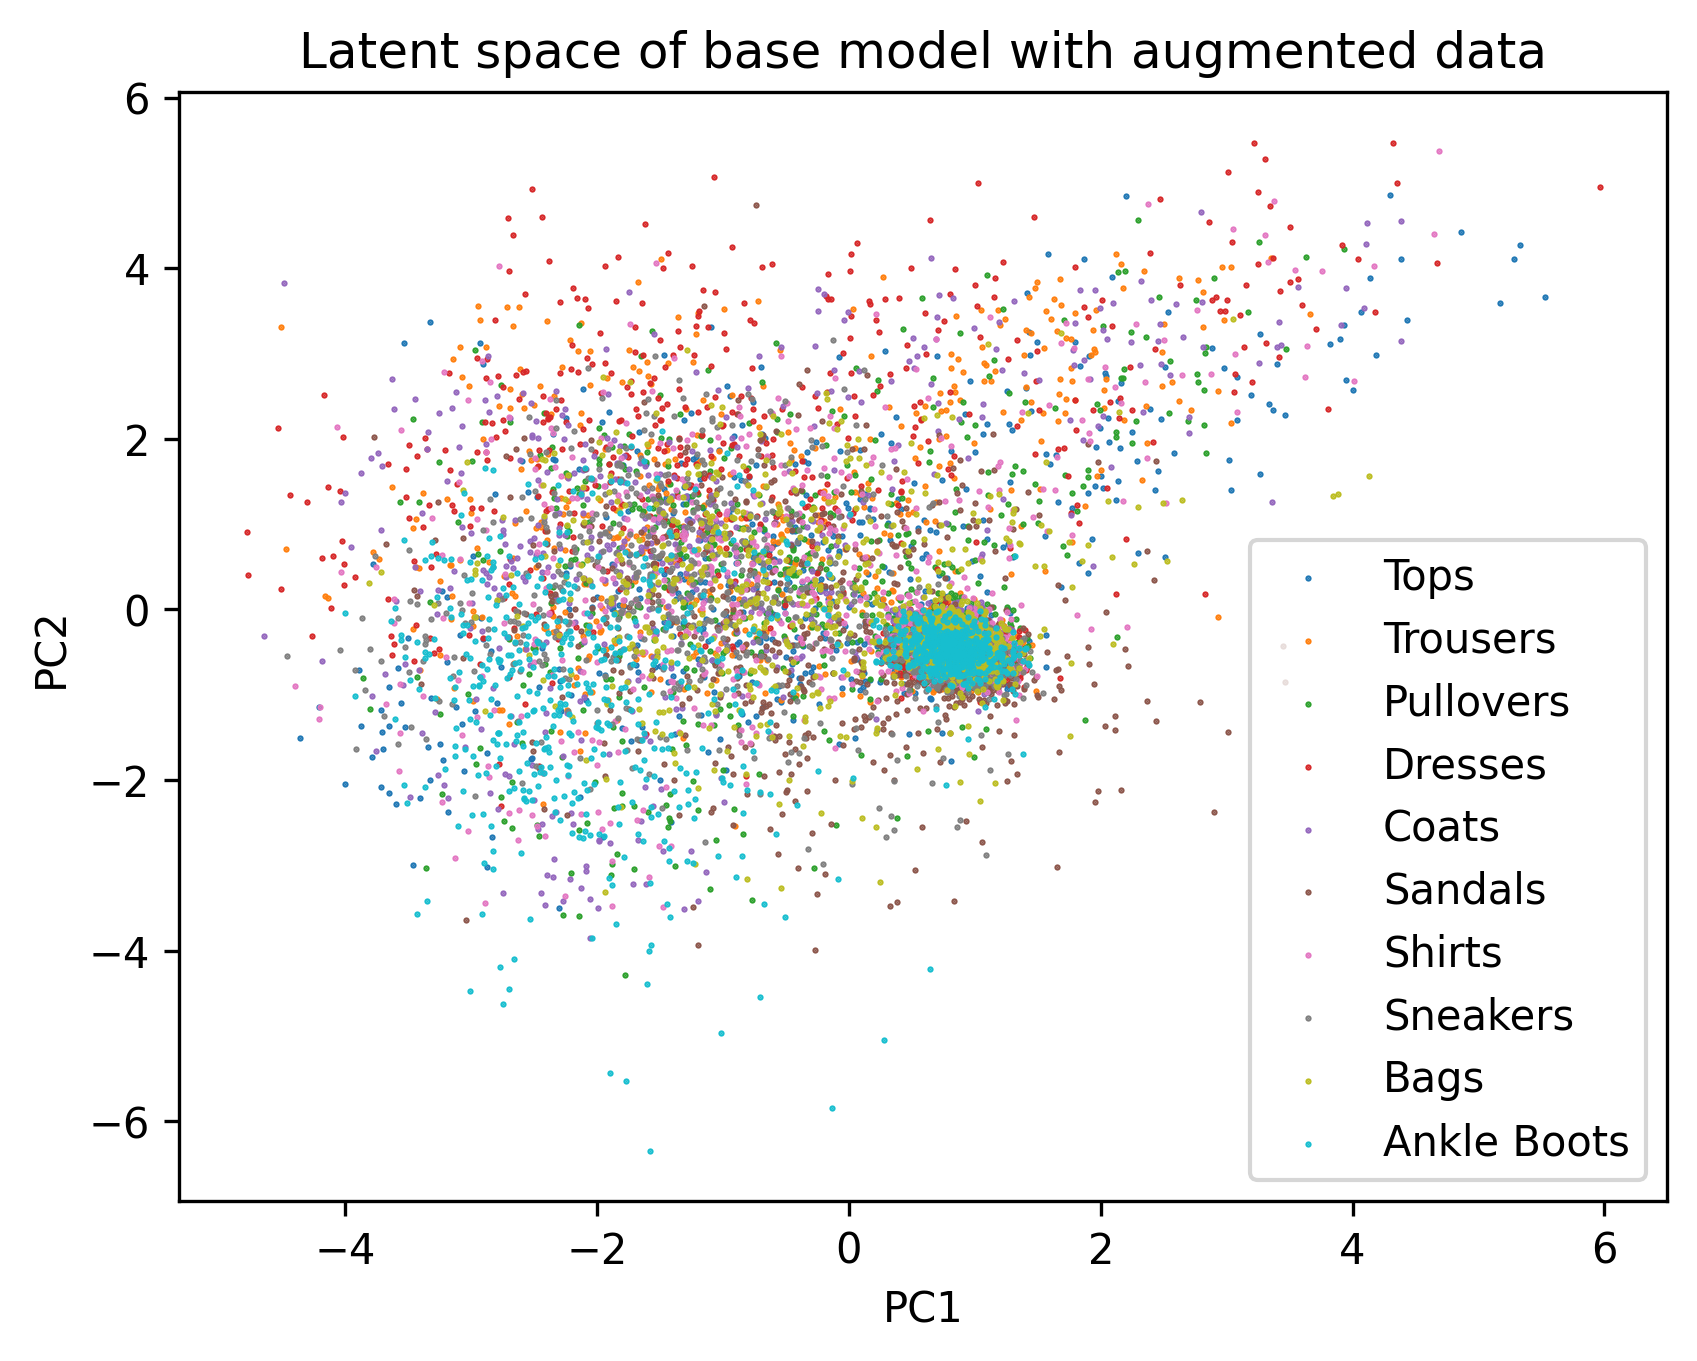

In [9]:
latent_plot(base_model, test_augment, title="Latent space of base model with augmented data")

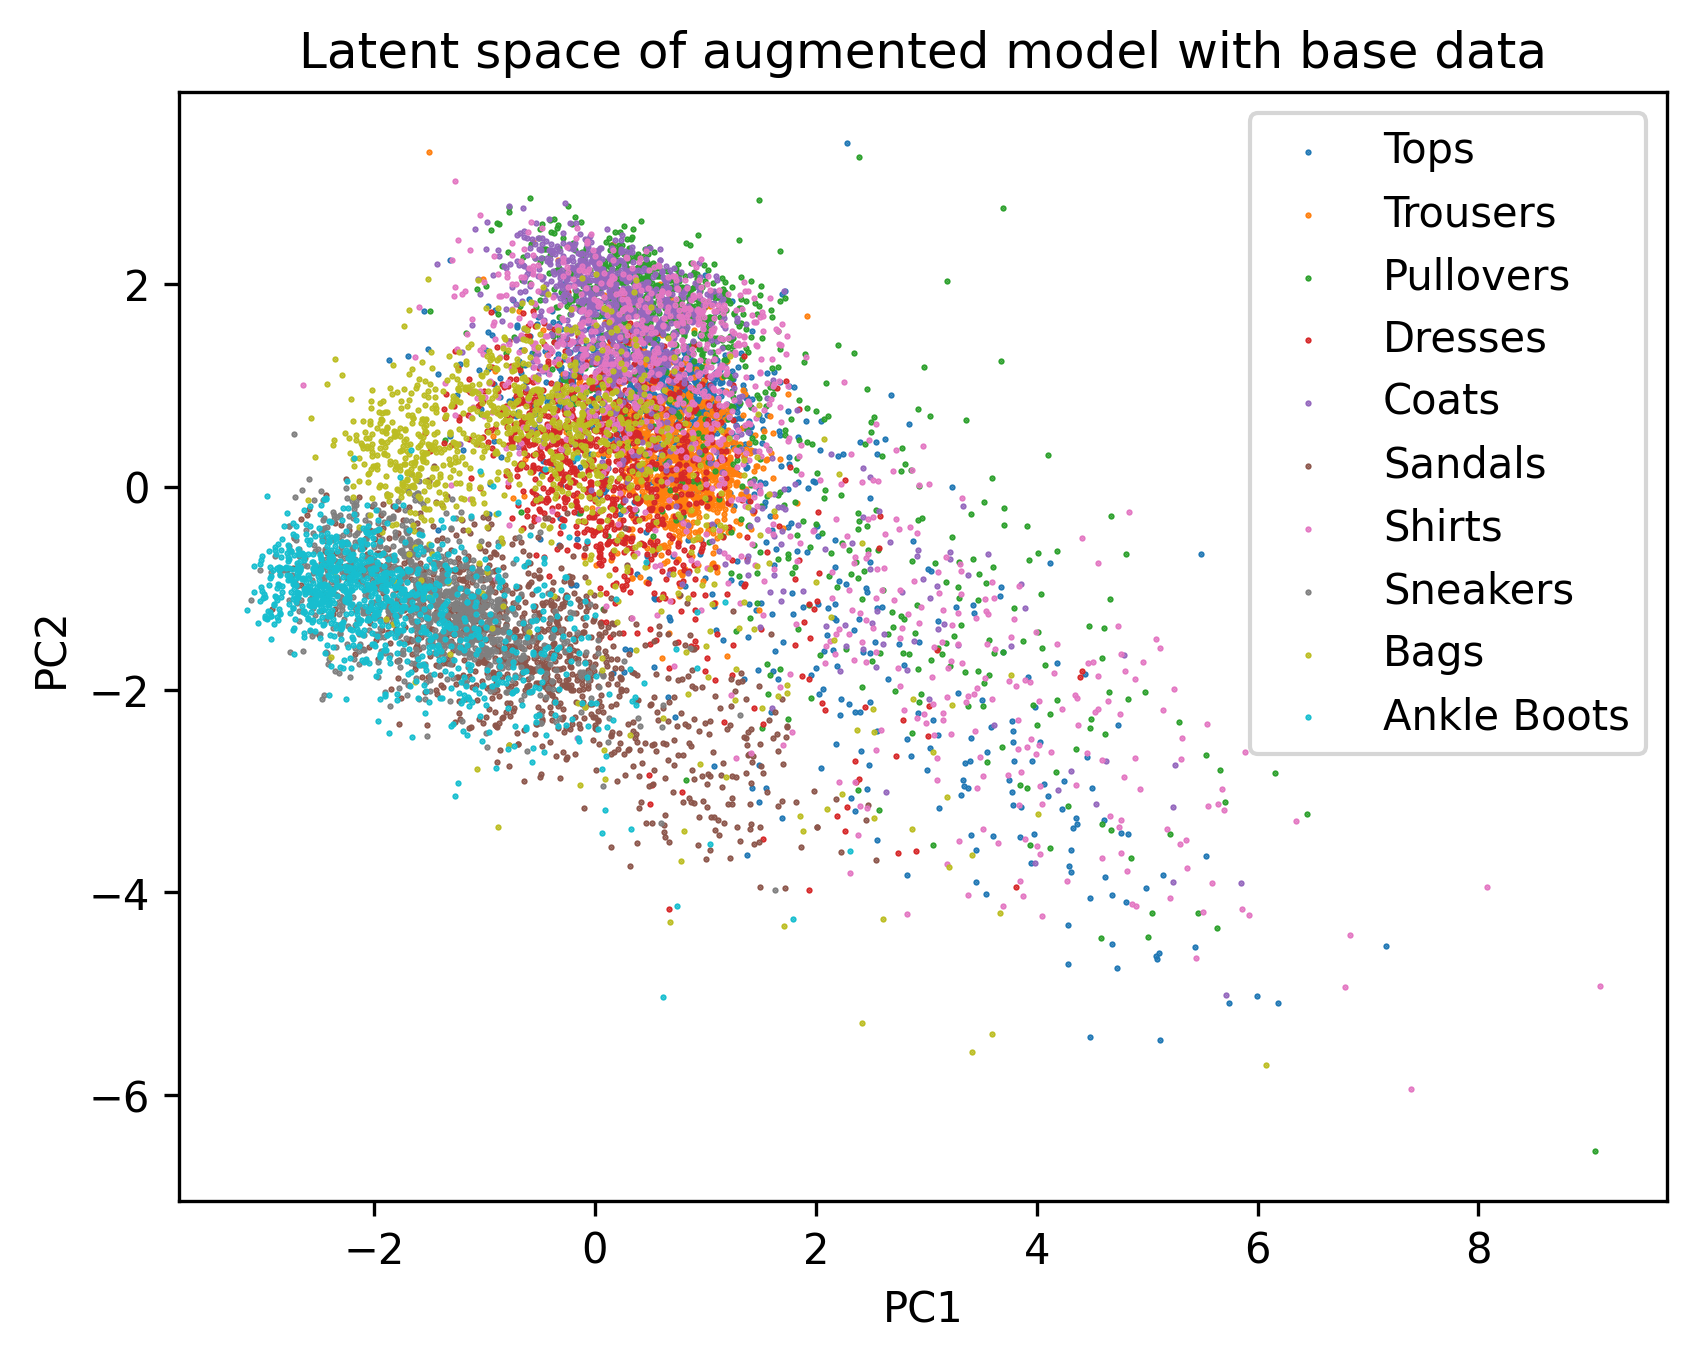

In [10]:
latent_plot(augment_model, test_base, title="Latent space of augmented model with base data")

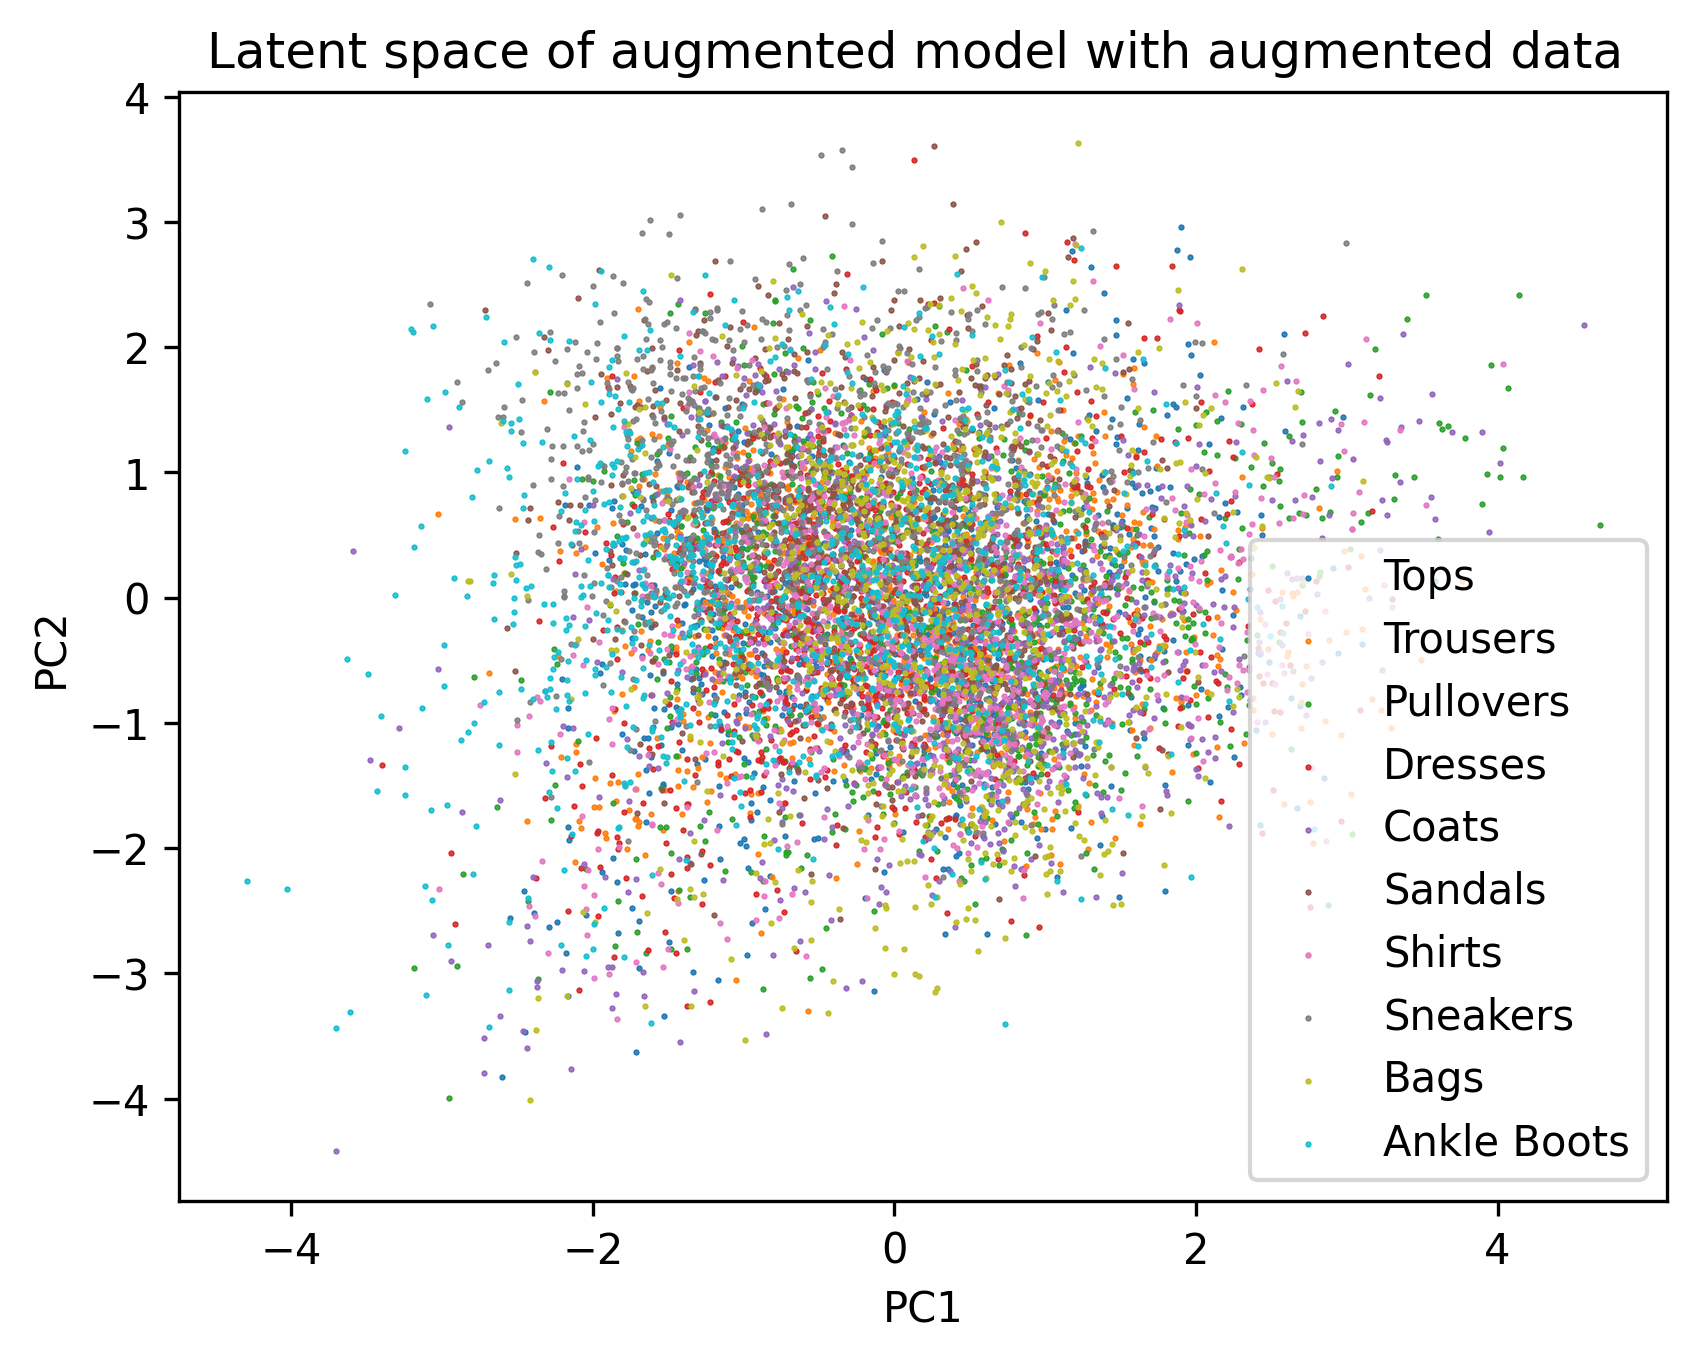

In [11]:
latent_plot(augment_model, test_augment, title="Latent space of augmented model with augmented data ")